In [ ]:
import numpy as np
from numpy.random import choice

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F

import math

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.integrate import odeint

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install cmasher
import cmasher as cmr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 10.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Burgers_data_np = np.load("/content/drive/MyDrive/Burgers_eq_data.pth.npy")

Burgers_data = torch.from_numpy(Burgers_data_np).type(torch.float32).to(device)

In [ ]:
# Generate training data

# Num of training samples
num_samples = 3000

np.random.seed(1)

# Spatial mesh
L_x = 1
dx = 0.005
N_x = int(L_x/dx + 1)
X = np.linspace(0,L_x,N_x)

# Temporal mesh
L_t = 1.0
dt = 0.005
N_t = int(L_t/dt + 1)
T = np.linspace(0,L_t,N_t)

k = 2*np.pi*np.fft.fftfreq(N_x, d = dx)

# Datasets for training
phi = torch.zeros(size=(N_x*num_samples,N_x))
v = torch.zeros(size=(N_x*num_samples,N_x))
t = torch.zeros(size=(N_x*num_samples,1))

# Dataset used to store entire numerical solutions
Phi = np.zeros(shape=(num_samples,N_x,N_t))

# Data loop
for num in range(num_samples):


  # Random coefficients
  alpha = np.random.uniform(-1,1,6)
  phi_0 = alpha[0]*np.cos(2*math.pi*X) + alpha[1]*(np.cos(2*math.pi*X))**3 + alpha[2]*(np.cos(2*math.pi*X))**5  \
           + alpha[3]*np.sin(2*math.pi*X) + alpha[4]*(np.sin(2*math.pi*X))**3 + alpha[5]*(np.sin(2*math.pi*X))**5

  def burg_system(u,t,k):
    mu = 1
    nu = 0.01
    u_hat = np.fft.fft(u)
    u_hat_x = 1j*k*u_hat
    u_hat_xx = -k**2*u_hat
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)
    u_t = -mu*u*u_x + nu*u_xx
    return u_t.real


  #phi_i = odeint(burg_system, phi_0, T, args=(k,), mxstep=5000).T

  phi_i = Burgers_data_np[num,:,:]

 # Phi[num,:,:] = phi_i

  time_indices = np.random.randint(0, T.size, N_x) #np.random.randint(0, 99, N_x) #np.random.randint(0, T.size, N_x)
  time_indices = np.arange(N_t)

  # Store data from Phi into suitable tensors for training.
  # These tensors are organized by (i) initial condition, (ii) later time for solution, (iii) later solution
  phi[num*N_x:(num+1)*N_x,0:N_x] = torch.from_numpy(phi_i[:,0])
  t[num*N_x:(num+1)*N_x,0] = torch.from_numpy(T[time_indices])
  v[num*N_x:(num+1)*N_x,0:N_x] = torch.from_numpy(np.transpose(phi_i[:,time_indices]))

  if num % 1000 == 0:
    print(num)

0
1000
2000


In [ ]:
File = "Burgers_geo_flow_data.pth"
np.save(File, Phi)

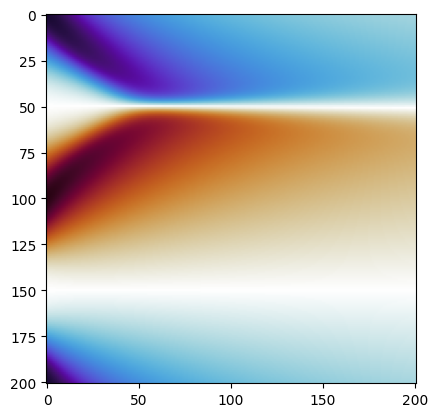

In [ ]:
plt.imshow(phi_i, cmap=cmr.fusion)

In [ ]:
# Initialize data with PyTorch for training

Phi = phi.type(torch.float32).to(device).requires_grad_()
V = v.type(torch.float32).to(device).requires_grad_()
times = t.type(torch.float32).to(device).requires_grad_()

In [ ]:
# Randomly sampled times
times_unif = np.random.uniform(0,1.0,size=(Phi.size(dim=0),1))
times_unif[0:num_samples] = 0
times_unif = torch.tensor(times_unif, requires_grad=True).type(torch.float32).to(device)

In [ ]:
w = 200
N_x = 201 # input width

intrinsic_dim = 3
extrinsic_dim =  2 * intrinsic_dim - 1

class parameterization_NN(nn.Module):
    def __init__(self):
        super(parameterization_NN, self).__init__()
        self.x_layer1 = nn.Linear(N_x,w,bias=True); self.x_layer2 = nn.Linear(w,w, bias=True); self.x_layer3 = nn.Linear(w,w, bias=True)
        self.x_mean_1 = nn.Linear(w,w, bias=True); self.x_mean_2 = nn.Linear(w,intrinsic_dim, bias=True)
        self.x_std_1 = nn.Linear(w,w, bias=True); self.x_std_2 = nn.Linear(w,intrinsic_dim, bias=True)

    def forward(self, u):
        inputs = u
        x1_out = F.tanh(self.x_layer1(inputs)); x2_out = F.tanh(self.x_layer2(x1_out)); x3_out = F.tanh(self.x_layer3(x2_out))
        x_mean_1 = F.tanh(self.x_mean_1(x3_out)); x_mean_2 = self.x_mean_2(x_mean_1)
        x_std_1 = F.tanh(self.x_std_1(x3_out)); x_std_2 = self.x_std_2(x_std_1)
        return x_mean_2, x_std_2

In [ ]:
class psi_NN(nn.Module):
    def __init__(self):
        super(psi_NN, self).__init__()
        self.x_layer1 = nn.Linear(intrinsic_dim+1,w,bias=True); self.x_layer2 = nn.Linear(w,w, bias=True)
        self.x_layer3 = nn.Linear(w,w, bias=True); self.x_layer4 = nn.Linear(w,1, bias=True)

    def forward(self, uv, tau):
        inputs = torch.cat((uv, tau),1)
        x1_out = F.gelu(self.x_layer1(inputs))
        x2_out = F.gelu(self.x_layer2(x1_out))
        x3_out = F.gelu(self.x_layer3(x2_out))
        x4_out = self.x_layer4(x3_out)
        return x4_out

In [ ]:
class encoder_NN(nn.Module):
    def __init__(self):
        super(encoder_NN, self).__init__()
        self.x_layer1 = nn.Linear(intrinsic_dim+1,w,bias=True); self.x_layer2 = nn.Linear(w,w, bias=True)
        self.x_layer3 = nn.Linear(w,w, bias=True); self.x_layer4 = nn.Linear(w,extrinsic_dim, bias=True)

    def forward(self, uv, tau):
        inputs = torch.cat((uv, tau),1)
        x1_out = F.tanh(self.x_layer1(inputs))
        x2_out = F.tanh(self.x_layer2(x1_out))
        x3_out = F.tanh(self.x_layer3(x2_out))
        x4_out = self.x_layer4(x3_out)
        return x4_out

In [ ]:
class decoder_NN(nn.Module):
    def __init__(self):
        super(decoder_NN, self).__init__()
        self.x_layer1 = nn.Linear(extrinsic_dim,w,bias=True); self.x_layer2 = nn.Linear(w,w, bias=True)
        self.x_layer3 = nn.Linear(w,w, bias=True); self.x_layer4 = nn.Linear(w,N_x, bias=True)

    def forward(self, u):
        x1_out = F.tanh(self.x_layer1(u))
        x2_out = F.tanh(self.x_layer2(x1_out))
        x3_out = F.tanh(self.x_layer3(x2_out))
        x4_out = self.x_layer4(x3_out)
        return x4_out

In [ ]:
# Create neural networks
parameterization = parameterization_NN().to(device) # local coordinates
psi = psi_NN().to(device) # Riemannian metric
encoder = encoder_NN().to(device) # encoder to manifold
decoder = decoder_NN().to(device) # decoder to PDE data

In [ ]:
optimizer = optim.Adam([
    {'params': parameterization.parameters()},
    {'params': psi.parameters()},
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
], lr=2e-4)

In [ ]:
parameterization.load_state_dict(torch.load("parameterization.pth"))
psi.load_state_dict(torch.load("psi.pth"))
encoder.load_state_dict(torch.load("encoder.pth"))
decoder.load_state_dict(torch.load("decoder.pth"))

<All keys matched successfully>

In [ ]:
# Reparameterization trick
def get_reparameterization_sample(parameterization, U, intrinsic_dim, N):
  means_eval, stds_eval = parameterization(U)

  random_normal = torch.normal(0,1,size=(N,intrinsic_dim), requires_grad=True).to(device)

  uv_sample = means_eval  +   stds_eval * random_normal

  return uv_sample

In [ ]:
# Create function to get metric coefficients of the encoder neural network (not g)
def induced_metric_func(encoder, uv, tau, intrinsic_dim, extrinsic_dim, N):

  encoder_uv = torch.zeros(size=(N,extrinsic_dim,intrinsic_dim)).to(device)
  encoded_rep = encoder(uv, tau)
  for col in range(encoder_uv.size(dim=1)):
    encoder_uv[:,col,:] = torch.autograd.grad(encoded_rep[:,col].sum(), uv, create_graph=True)[0]

  encoder_metric = torch.zeros(size=(N,intrinsic_dim,intrinsic_dim)).to(device)

  for i in range(intrinsic_dim):
    for j in range(i+1):
      encoder_metric[:,i,j] = torch.sum( torch.squeeze(encoder_uv[:,:,i]) * torch.squeeze(encoder_uv[:,:,j]), dim=1)
      encoder_metric[:,j,i] = encoder_metric[:,i,j]

  return encoder_metric

In [ ]:
# Compute inverse of metric
def g_inv(G):
  G_inv = torch.linalg.pinv(G).to(device)
  return G_inv

In [ ]:
# Laplace-Beltrami of psi
def laplace_beltrami_func(psi, uv, tau, g, N):

  psi_eval = psi(uv, tau)
  epsilon = 1e-12

  # Get partials
  psi_partials = torch.zeros(size=(N,intrinsic_dim)).to(device)
  psi_partials[:,:] = torch.autograd.grad(psi_eval[:,0].sum(), uv, create_graph=True)[0][:,:]

  det_g = torch.linalg.det(g)
  g_in = g_inv(g) #torch.clamp(g_inv(g), min=1e-5, max=100)

  # Sum metric inverse with partials
  g_psi_sum = torch.einsum('nij,nj->ni', g_in, psi_partials)
  g_psi_sum_det = ((det_g)**(1/2)).unsqueeze(dim=1) * g_psi_sum

  # Compute divergence
  divergence = torch.zeros(size=(N,1), requires_grad=True).to(device)
  for i in range(intrinsic_dim):
    divergence += torch.autograd.grad(g_psi_sum_det[:,i].sum(), uv, create_graph=True)[0][:,i].unsqueeze(1)

  # Final Laplace-Beltrami
  laplace_beltrami_final = ((det_g + epsilon)**(-1/2)).unsqueeze(dim=1) * divergence

  return laplace_beltrami_final



In [ ]:
# Closed form scalar curvature computation
def scalar_curvature_func(psi, laplace_beltrami, R, uv, tau, g, N, d):

  psi_eval = psi(uv, tau)
  det_g = torch.linalg.det(g)
  epsilon = 1e-18

  scalar_curvature =  (   (4*(d-1)/(d-2)) * laplace_beltrami - R * psi_eval   ) * psi_eval  * (torch.abs(det_g)**(1/2) ).unsqueeze(dim=1)

  return scalar_curvature

In [ ]:
# Initialize metric with that of the sphere

def g0_func(uv, tau, d, N):

  sin_uv = torch.sin(uv)
  metric_sphere = torch.zeros(size=(N,intrinsic_dim,intrinsic_dim)).to(device)
  metric_sphere[:,0,0] = 5 # 5 is for a radius
  for i in range(1,intrinsic_dim):
    metric_sphere[:,i,i] = 5  * torch.prod(sin_uv[:,0:i]**2, dim=1)

  # Add regularization with identity to prevent degeneracy / computation error
  metric_sphere += 0.002 * torch.eye(d, device=metric_sphere.device).unsqueeze(0).expand(N, d, d)

  return metric_sphere

In [ ]:
# Decoded loss for ambient PDE data
def loss_decoded_func(Phi_t, uv, tau, encoder, decoder, parameterization, N):

  encoded_rep = encoder(uv, tau)
  decoded_rep = decoder(encoded_rep)

  diff = decoded_rep - Phi_t
  loss = (1/torch.numel(diff)) * torch.norm(diff)**2

  return loss

In [ ]:
# KL divergence regularization with a Gaussian prior
def loss_kl_func(parameterization, Phi_0, N):

  means_eval, stds_eval = parameterization(Phi_0)
  epsilon = 1e-18

  kl_loss =  -torch.sum(1 + torch.log(stds_eval**2 + epsilon) - means_eval**2 - stds_eval**2, dim=1)

  return torch.mean(kl_loss)

In [ ]:
# Create loss function between the metric neural network and the computed metric with the encoder

def loss_metric_func(psi, g_0, encoder, Phi, uv, tau, N, d, D):

  # Compute g neural network output
  psi_eval = psi(uv, tau)
  g_rep = ( psi_eval**(4/(d-2)) ).unsqueeze(1) * g_0

  # Compute matrix inner product
  inner_product_matrix = induced_metric_func(encoder, uv, tau, d, D, N)

  # Compute difference matrix
  diff =  g_rep  - inner_product_matrix

  # Return loss, which is a scaled matrix norm
  loss = (1/torch.numel(diff))*torch.norm(diff)**2
  return loss

In [ ]:
# Perelman functional loss
def perelman_functional_loss(scalar_curvature, tau, N):

  scalar_curv_time_deriv = torch.autograd.grad(scalar_curvature.sum(), tau, create_graph=True)[0][:,0]
  loss = torch.abs(50 - torch.mean(scalar_curv_time_deriv))**2
  return loss

In [ ]:
index = 0


# Store metric data if this is useful
g_metric_iter = torch.zeros(size=(10000,intrinsic_dim,intrinsic_dim)).to(device)

In [ ]:
# Training algorithm

num_iter = 100

# Large batch size works well
N = 800

import time
start = time.time()

for num in range(num_iter):

  I = np.random.randint(0,int(num_samples*N_x),N)

  uv = get_reparameterization_sample(parameterization, Phi[I,:], intrinsic_dim, N)
  tau = times[I,:]
  tau_unif = times_unif[I,:]

  g0 = g0_func(uv, tau, intrinsic_dim, N)
  psi_eval = torch.clamp(psi(uv, tau), min=0.5)
  g_rep = ( psi_eval**(4/(intrinsic_dim-2)) ).unsqueeze(1) * g0


  R = intrinsic_dim * (intrinsic_dim - 1) / (5**2)

  g_induced = induced_metric_func(encoder, uv, tau, intrinsic_dim, extrinsic_dim, N)
  laplace_beltrami = laplace_beltrami_func(psi, uv, tau, g0, N)
  scalar_curvature = scalar_curvature_func(psi, laplace_beltrami, R, uv, tau, g0, N, intrinsic_dim)


  loss_perelman = perelman_functional_loss(scalar_curvature, tau, N)
  loss_kl = loss_kl_func(parameterization, Phi[I,:], N)
  loss_decoded = loss_decoded_func(V[I,:], uv, tau, encoder, decoder, parameterization, N)
  loss_metric = loss_metric_func(psi, g_rep, encoder, Phi, uv, tau, N, intrinsic_dim, extrinsic_dim)

  loss =   1000 * loss_decoded  +   0.001 * loss_kl + loss_perelman  + 1 * loss_metric

  optimizer.zero_grad()
  loss.backward()

  torch.nn.utils.clip_grad_value_(parameterization.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(psi.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(encoder.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(decoder.parameters(), 1.)

  optimizer.step()


  if num % 20 == 0:
    index += 1
    g0 = g0_func(uv, tau, intrinsic_dim, N)
    psi_eval = psi(uv, tau)
    g_rep = ( psi_eval**(4/(intrinsic_dim-2)) ).unsqueeze(1) * g0
    g_metric_iter[index,:,:] = torch.mean(g_rep.squeeze().clone(), dim=0)
    print(torch.mean(psi_eval[:,:]**(4/(intrinsic_dim-2))))
    print("Training loss:", '{:.4e}'.format(loss.data), \
          "Decoded:", '{:.4e}'.format(loss_decoded.data), \
          "Geo flow:", '{:.4e}'.format(loss_perelman.data), \
          "KL:", '{:.4e}'.format(loss_kl.data), \
          "Metric:", '{:.4e}'.format(loss_metric.data))


end = time.time()
print(f"Elapsed time: {end - start:.6f} seconds")

tensor(3.4827, device='cuda:0', grad_fn=<MeanBackward0>)
Training loss: 3.5836e+01 Decoded: 2.2377e-02 Geo flow: 1.2664e+01 KL: 1.4507e+01 Metric: 7.8074e-01
tensor(3.7964, device='cuda:0', grad_fn=<MeanBackward0>)
Training loss: 9.0544e+01 Decoded: 1.9035e-02 Geo flow: 7.0802e+01 KL: 1.4319e+01 Metric: 6.9291e-01
tensor(3.2726, device='cuda:0', grad_fn=<MeanBackward0>)
Training loss: 8.1125e+01 Decoded: 1.8763e-02 Geo flow: 6.1808e+01 KL: 1.6662e+01 Metric: 5.3646e-01
tensor(3.1843, device='cuda:0', grad_fn=<MeanBackward0>)
Training loss: 1.6739e+01 Decoded: 1.5788e-02 Geo flow: 4.2412e-01 KL: 1.6652e+01 Metric: 5.0952e-01
tensor(3.2181, device='cuda:0', grad_fn=<MeanBackward0>)
Training loss: 2.2100e+01 Decoded: 1.4857e-02 Geo flow: 6.7450e+00 KL: 1.6892e+01 Metric: 4.8096e-01
Elapsed time: 11.657198 seconds


In [ ]:
# Save newly-trained neural networks to current directory

File = "parameterization.pth"
torch.save(parameterization.state_dict(), File)

File = "psi.pth"
torch.save(psi.state_dict(), File)

File = "encoder.pth"
torch.save(encoder.state_dict(), File)

File = "decoder.pth"
torch.save(decoder.state_dict(), File)

In [ ]:
print(g_metric_iter[5,:,:])

tensor([[2.7198e-04, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 2.4813e-06, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.2250e-06]], device='cuda:0',
       grad_fn=<SliceBackward0>)


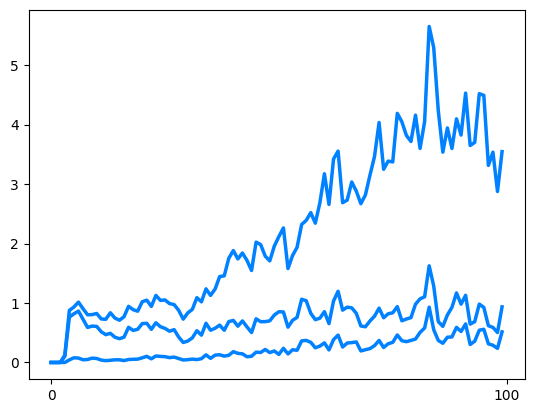

In [ ]:
# Riemannian metric means

Num_ = 100

colors = plt.cm.jet(np.linspace(0, 1, 5))  # 5 distinct colors from the colormap

for i in range(3):
    plt.plot(g_metric_iter[0:Num_, i, i].cpu().detach().numpy(), linewidth=2.5, color=colors[1])
  #  plt.plot(g_metric_iter[0:Num_, 0, 1].cpu().detach().numpy(), linewidth=2.5, color=colors[3])
  #  plt.plot(g_metric_iter[0:Num_, 0, 2].cpu().detach().numpy(), linewidth=2.5, color=colors[3])
  #  plt.plot(g_metric_iter[0:Num_, 1, 2].cpu().detach().numpy(), linewidth=2.5, color=colors[3])

plt.xticks(ticks=[0,100])
#plt.yticks(ticks=[0,2.5,5])

plt.savefig('metric.png', dpi=300)

In [ ]:
# Inference testing

np.random.seed(21)

phi_test = torch.zeros(size=(1,N_x,N_t)).to(device)
alpha = np.random.uniform(-1,1,6)
phi_0 = alpha[0]*np.cos(2*math.pi*X) + alpha[1]*(np.cos(2*math.pi*X))**3 + alpha[2]*(np.cos(2*math.pi*X))**5  \
         #  + alpha[3]*np.sin(2*math.pi*X) + alpha[4]*(np.sin(2*math.pi*X))**3 + alpha[5]*(np.sin(2*math.pi*X))**5


phi_i_test = odeint(burg_system, phi_0, T, args=(k,), mxstep=5000).T
phi_test[0,:,:] = torch.from_numpy(phi_i_test).to(device)


phi_test_noise = phi_test.clone()
noise = np.random.normal(0,1.5, size=(201))
noise[np.random.choice(201,100, replace=False)] = 0
phi_test_noise[0,:,0] = 1.0*phi_test[0,:,0]   +   torch.from_numpy(noise).to(device)

In [ ]:
decoded_2d = torch.zeros(size=(N_x,N_t))

for num in range(N_t):
  t_test = (num/(N_t))*torch.ones(size=(1,1)).to(device)
  t_index = int(t_test*100)

  means_eval, stds_eval = parameterization(phi_test_noise[0,:,0])
  random_normal = torch.normal(0,1,size=(1,intrinsic_dim), requires_grad=True).to(device)
  uv_sample = means_eval

  encoded_rep = encoder(uv_sample.unsqueeze(0), t_test)
  decoded_rep = decoder(encoded_rep)

  decoded_2d[:,num] = decoded_rep

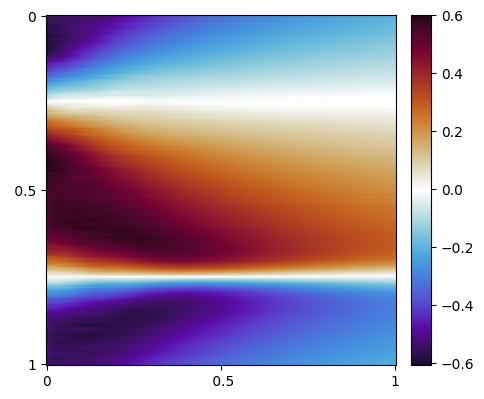

In [ ]:
heatmap2d(decoded_2d.cpu().detach().numpy())

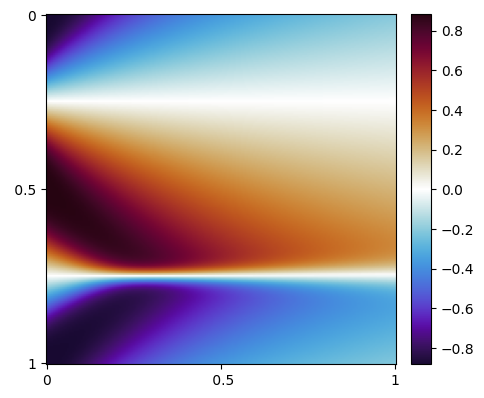

In [ ]:
heatmap2d(phi_test[0,:,:].cpu().detach().numpy())

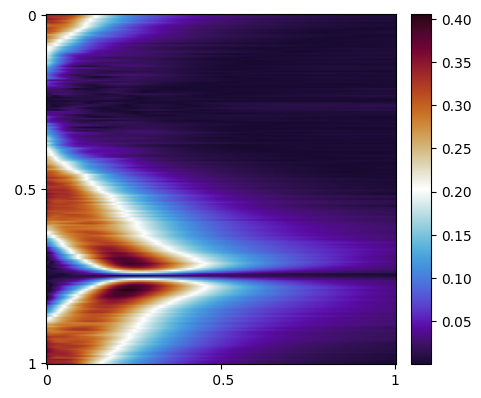

In [ ]:
heatmap2d( np.abs( decoded_2d.cpu().detach().numpy() - phi_test[0,:,:].cpu().detach().numpy() ) )

In [ ]:
print( np.sum(np.abs( decoded_2d.cpu().detach().numpy() - phi_test[0,:,:].cpu().detach().numpy() ) )    / np.sum(np.abs( phi_test[0,:,:].cpu().detach().numpy() ) )       )

0.2046363


In [ ]:
def heatmap2d(u):

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

  im = ax.imshow(u[:,:], cmap=cmr.fusion_r)
                 #  vmin=-10, vmax=10)
  ax.set_xticks([0,100,200], ['0', ' 0.5', '1'])
  ax.set_yticks([0,100,200], ['0', ' 0.5', '1'])
  #ax.set_xticks([])
  #ax.set_yticks([])
  ax.grid(False)

  fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.3, hspace=0.3)

  cb_ax = fig.add_axes([0.83, 0.15, 0.04, 0.7])
  cbar = fig.colorbar(im, cax=cb_ax)

  #cbar.ax.set_yticks((-10,-5,0,5,10))
  plt.savefig('burgers.png', dpi=700)
  plt.show()

In [ ]:
# Get errors
num_errors = 300
skip = 10 # Skip every P discretized points to help inference run faster; this is optional and has no impact on results


errors = np.zeros(shape=(num_errors,N_t))

np.random.seed(1)

for num_sample in range(num_errors):

  rand_i = np.random.randint(0,3000,1).squeeze()
  uu_test = torch.zeros(size=(1,201,201)).to(device)
  uu_test[0,:,:] = torch.from_numpy(Burgers_data_np[rand_i,:,:]).to(device)


  uu_test_noise = torch.zeros(size=(1,N_x,N_t)).to(device)
  uu_test_noise = uu_test.clone()
  noise = np.random.normal(0,3.0, size=(201))
  noise[11:201] = 0
 # noise[np.random.choice(201,100, replace=False)] = 0
 # scaling = 2*np.pi*torch.range(0,200,1).to(device) / 201
  uu_test_noise[:,:,0] = 1.0*uu_test[:,:,0]    + torch.from_numpy(noise).to(device)


  decoded_2d = torch.zeros(size=(N_x,1))

  for num in range(0, N_t, skip):
    t_test = T[num]*torch.ones(size=(1,1)).to(device)
    t_index = num

    means_eval, stds_eval = parameterization(uu_test_noise[:,:,0].unsqueeze(0))
    random_normal = torch.normal(0,1,size=(1,intrinsic_dim), requires_grad=True).to(device)
    uv_sample = means_eval

    encoded_rep = encoder(uv_sample.squeeze().unsqueeze(0), t_test)
    decoded_rep = decoder(encoded_rep)

    decoded_2d[:,0] = decoded_rep

    # Relative L1 error
    errors[num_sample,num] =  np.sum(np.abs(decoded_2d.cpu().detach().numpy().squeeze()  - uu_test[0,:,num].cpu().detach().numpy() ) ) \
                          / np.sum(np.abs(uu_test[0,:,num].cpu().detach().numpy()))

In [ ]:
print(np.mean(errors[:,::skip]))
print(np.std(errors[:,::skip]))

0.4156506819360786
0.9123827347020256
